# PROJET 8 - Voiture Autonome
<div>
    <center><img src="./prez_images/Capture.png" width="300"/></center>
</div>

Future Vision Transport est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

Voici les différentes parties du système :

1. acquisition des images en temps réel
2. traitement des images
3. segmentation des images
4. système de décision

### Objectifs
- concevoir un premier modèle de segmentation d’images qui devra s’intégrer facilement dans la chaîne complète du système embarqué

Pour récapituler, on doit suivre le plan d’action, avec les points suivants :

 - entraîner et déployer un modèle de segmentation des images sur les 8 catégories principales en utilisant Azure Machine Learning. Keras est le framework de travail commun à toute l’équipe. Attention aux contraintes de Franck !
- déployer une API Flask grâce au service Azure qui sera utilisée par Laura.

### Jeu de données
Il s'agit de dataset Cityscapes, images prises par des caméras embarquées d'une voiture circulant dans les villes en Allemagne. 

# Chargement des données

In [5]:
import os, shutil
from pathlib import Path
import pandas as pd

def list_files(dir, endswith, loop_subfolders=False, move=False):
    path_list = []
    with os.scandir(dir) as it:
        for iter in it:
            if iter.is_dir():

                if loop_subfolders == True:
                    list_files(dir=iter, endswith=endswith, 
                               loop_subfolders = loop_subfolders, 
                               move=move)
                else:
                    pass

            elif iter.is_file():
                if iter.name.endswith(endswith):
                    # print(iter.name, iter.path)
                    path_list.append(iter.name) 
                    
                    if move == True:
                        shutil.move(iter.path, mask_dir + str(iter.name))
                        # print(iter.name)
                        # print(iter.name, iter.path)

    return path_list

WHICH_ONE = 'P8_dataset_full'
# WHICH_ONE = 'P8_dataset_small'

# move_dir = Path('C:/Users/marko/Desktop/' + WHICH_ONE + '/images/train/')
main_dir = Path('C:/Users/marko/Desktop/' + WHICH_ONE + '/images/train/')
main_dir1 = Path('C:/Users/marko/Desktop/' + WHICH_ONE + '/images/val/')

mask_dir = Path('C:/Users/marko/Desktop/' + WHICH_ONE + '/ground_truth/train/')
mask_dir1 = Path('C:/Users/marko/Desktop/' + WHICH_ONE + '/ground_truth/val/')

img_end = '.png'
mask_color= 'gtFine_color.png'
mask_black_white = 'gtFine_labelIds.png'

train_img = list_files(main_dir, endswith=img_end, 
           loop_subfolders=False, move=False)

train_labels = list_files(mask_dir, endswith=mask_color, 
           loop_subfolders=False, move=False)

valid_img = list_files(main_dir1, endswith=img_end, 
           loop_subfolders=False, move=False)

valid_labels = list_files(mask_dir1, endswith=mask_color, 
           loop_subfolders=False, move=False)

# create dataframes to store them and pass them to generator
df_train_temp = pd.DataFrame(
            {'xPathLabel' : train_img,
            'yPathLabel' : train_labels,
            })

# on va séparer ce jeu en train/test
df_valid = pd.DataFrame({'xPathLabel' : valid_img,
            'yPathLabel' : valid_labels,
            })

SPLIT_PERC = 0.8
split = int(SPLIT_PERC * float(df_train_temp.shape[0]))

df_train = df_train_temp[:split]
df_test = df_train_temp[split:]


In [6]:
# Add path prefix for each set of data
df_train.loc[:,'xPathLabel'] = 'images/train/' + df_train.loc[:,'xPathLabel'].astype(str)
df_train.loc[:,'yPathLabel'] = 'ground_truth/train/' + df_train.loc[:,'yPathLabel'].astype(str)

df_test.loc[:,'xPathLabel'] = 'images/train/' + df_test.loc[:,'xPathLabel'].astype(str)
df_test.loc[:,'yPathLabel'] = 'ground_truth/train/' + df_test.loc[:,'yPathLabel'].astype(str)

df_valid.loc[:,'xPathLabel'] = 'images/val/' + df_valid.loc[:,'xPathLabel'].astype(str)
df_valid.loc[:,'yPathLabel'] = 'ground_truth/val/' + df_valid.loc[:,'yPathLabel'].astype(str)


C:\Users\marko\anaconda3\envs\p8Azure\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [15]:
print(df_train.shape, df_test.shape, df_valid.shape)

(2380, 2) (595, 2) (500, 2)


In [14]:
#on récupére toutes les images dans une liste pour la passer à Azure
img_list = []
mask_list = []

for df in [df_train, df_test, df_valid]:
    img_list += df['xPathLabel'].to_list()
    mask_list += df['yPathLabel'].to_list()


# Télécharger sur Datastore d'Azure

In [1]:
WS_NAME = os.environ.get('WS_NAME')
SUBSCRIPTION = os.environ.get('SUBSCRIPTION_ID_FREE_STUDENTS')
RESSOURCE_GROUP = os.environ.get('RESSOURCE_GROUP')

In [2]:
from azureml.core import Workspace, Dataset, Datastore

# On charge l’espace de travail Azure Machine Learning existant
WS_NAME = os.environ.get('WS_NAME')
SUBSCRIPTION = os.environ.get('SUBSCRIPTION_ID_FREE_STUDENTS')
RESSOURCE_GROUP = os.environ.get('RESSOURCE_GROUP')

# si WS n'existe pas, il faut le créer
try:
    ws = Workspace.get(name=WS_NAME,
               subscription_id=SUBSCRIPTION,
               resource_group=RESSOURCE_GROUP)
except:
    ws = Workspace.create(name=WS_NAME,
                        subscription_id=SUBSCRIPTION,
                        resource_group=RESSOURCE_GROUP,
                        create_resource_group=False,
                        location='northeurope'
                        )

# ws = Workspace.from_config()
# On charge le magasin de données par défaut


 ##### On upload les images dans le magasin de données

In [17]:
# On upload les images dans le magasin de données

datastore = ws.get_default_datastore()

relative_root = "C:\\Users\\marko\\Desktop\\" + WHICH_ONE + "\\"

# datastore.upload_files(    
#     files=[str(relative_root + i) for i in img_list],
#     relative_root=None,
#     target_path='cityscapes/images',
#     overwrite=True,
#     show_progress=False
# )

# datastore.upload_files(    
#     files=[str(relative_root + m) for m in mask_list],
#     relative_root=None,
#     target_path='cityscapes/ground_truth',
#     overwrite=True,
#     show_progress=False
# )

# # for new version of Azure
ds = datastore.upload(src_dir=relative_root,
           target_path='cityscapes',
           show_progress=False)

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


### Enregistrer les datasets
afin de pouvoir les consommer dans les scripts, on va enregistrer les datasets

In [18]:
# On enregistre toutes les images en tant que Dataset
cityscape_ds = Dataset.File.from_files(path=(datastore, "cityscapes/"))
cityscape_ds = cityscape_ds.register(
    workspace=ws,
    name="cityscapes",
    tags={"type": "image"},
    description="Cityscape image dataset"
)

'Pour consommer'
# # azureml-core of version 1.0.72 or higher is required
# from azureml.core import Workspace, Dataset

# subscription_id = 'd4258567-1f40-439d-93e3-23364c743517'
# resource_group = 'OpenClassroms'
# workspace_name = 'p8_ws'

# workspace = Workspace(SUBSCRIPTION, RESSOURCE_GROUP, WS_NAME)

# dataset = Dataset.get_by_name(workspace, name='cityscapes')
# dataset.download(target_path='.', overwrite=False)

'Pour consommer'

 ### Enregistrer les df comportant les noms des fichiers

 On enregistre les jeux de données

In [19]:
 # On enregistre les jeux de données
train_ds = Dataset.Tabular.register_pandas_dataframe(
    dataframe=df_train,
    target=(datastore, "df_train"),
    name="df_train",
    tags={"type": "train_list"},
    description="Train data"
)

test_ds = Dataset.Tabular.register_pandas_dataframe(
    dataframe=df_test,
    target=(datastore, "df_test"),
    name="df_test",
    tags={"type": "test_list"},
    description="Test data"
)

valid_ds = Dataset.Tabular.register_pandas_dataframe(
    dataframe=df_valid,
    target=(datastore, "df_valid"),
    name="df_valid",
    tags={"type": "valid_list"},
    description="Validation data"
)

'Pour consommer'
# # azureml-core of version 1.0.72 or higher is required
# # azureml-dataprep[pandas] of version 1.1.34 or higher is required
# from azureml.core import Workspace, Dataset

# workspace = Workspace(SUBSCRIPTION, RESSOURCE_GROUP, WS_NAME)

# df_train = Dataset.get_by_name(workspace, name='df_train')
# df_train.to_pandas_dataframe()

# df_test = Dataset.get_by_name(workspace, name='df_test')
# df_test.to_pandas_dataframe()

# df_valid = Dataset.get_by_name(workspace, name='df_valid')
# df_valid.to_pandas_dataframe()

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to df_train/63045549-e60d-4f4f-9242-d3f8ac2d22cf/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to df_test/8fe0c6d6-4f5b-4c89-9b9d-e5abb47a816e/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to df_valid/ee31137e-e5db-4639-9afd-4b3bd9220e0b/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


'Pour consommer'

# Augmentation des données

Il est convenu qu'il faut faire un changement dans les données de base car l'étape précédent la détéction des objets (capture des images par la caméra embarquée) n'est pas stable. 

Dans ce but, on va utiliser la librairie Albumentations afin de transformer les données et rendre plus réaliste le jeu envoyé au réseau via Keras. 

        !!! A.Compose propose d'envoyer à la fois image et mask afin de faire le meme traitement sur les deux.
        En retour il nous renvoie un dictionnaire avec clés: image et mask 
        (ou uniquement image si maks = est vide)

Pour voir la liste de toutes les augmentations possibles [CLIQUEZ ICI](https://albumentations.ai/docs/getting_started/image_augmentation/)        

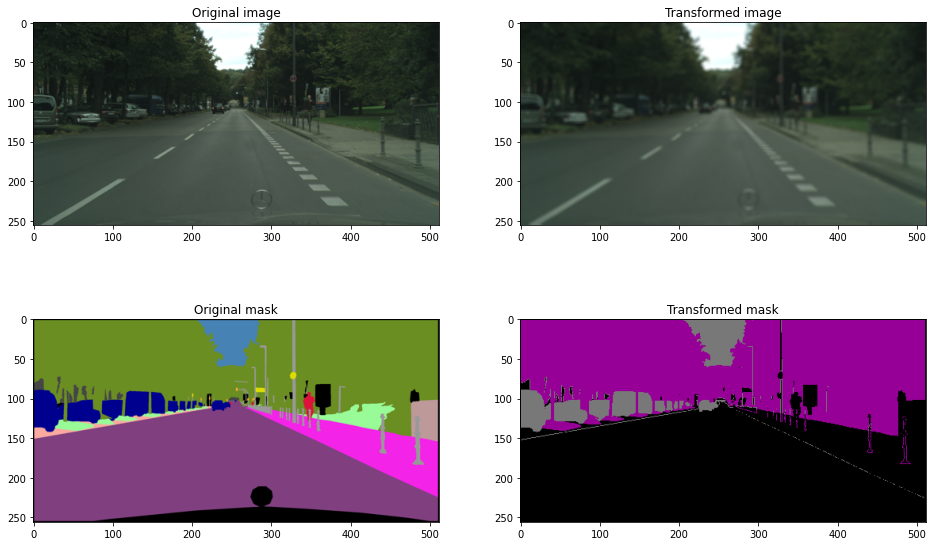

In [33]:
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
from scripts.helper_functions import  visualize

def get_augmented_images(image_array, mask_array):
    '''
    image, mask as numpy array
    '''
    # créer quelques transformation pour le test
    transform_pipe = A.Compose([
                    A.HorizontalFlip(p=0.75),
                    A.RandomBrightnessContrast(p=0.9),
                    A.Blur(p=0.9),
                    ])

    transformed = transform_pipe(image=image_array, mask=mask_array)
    # renvoie le dictionnaire
    return transformed

x_img = Image.open('./00 data/sample/aachen_000006_000019_leftImg8bit.png').convert('RGB')
x_image = x_img.resize((512,256))
x_array = np.array(x_image)

y_img = Image.open('./00 data/sample/aachen_000006_000019_gtFine_color.png').convert('RGB')
y_image = y_img.resize((512,256))
mask_array = np.array(y_image)

transformed = get_augmented_images(x_array, mask_array)

visualize(transformed['image'],transformed['mask'], x_array, mask_array)

# Model Selection

L'objectif du projet est de convevoir un modèle de ségmentation sémantique d'images. On va devoir séléctionner la métrique à utiliser et la fonction de perte adaptée, puis tester plusieurs modèles afin d'en choisir meilleur. 

Pour résumer:
- jusqu'à présent on a utilisé les modèles 
    - de prédiction: 
        - output = valeur décimale (une seule sortie)
        - métrique = erreur quadratique, erreur moyenne etc.
        - fonction de perte = Mean squared error loss
    - de classification (binaire ou multiclasse): 
        - output = 1 ou plusieurs sorties (avec probabilité)
        - métrique = accuracy, f1 score, matrice de confusion etc.
        - fonction de perte = Cross-Entropy (Logarithmic Loss)
    - de clustering:
        - output = une valeur par feature (classe)
        - métrique = coeff de silhouette, Calinski-Harabasz Index
        - fonction de perte = silhouette loss function etc
- ici il est question non pas de prédire une valeur par image, mais de prédire chaque pixel et sa classe
    - Ceci nécessite donc des changement suivants: 
        - le modèle de réseau de neuronnes doit être adapté afin de pouvoir délivrer en sortie une matrice égale à celle de l'entrée (W x H x Classe). Pour ce faire, il faut adopter les structures de encoder-decoder car les réseaux classiques utilisent le pooling afin de diminer la taille des inputs et pouvoir interpréter les détails. Ici, une fois arrivé au point de compression, il faut décompresser les données sur la deuxième partie du réseau afin de retrouver la taille originale. On va donc utiliser les modèles de type U (nomé par leur forme de compression-decompression)
        - on a besoin, a côté de l'image d'avoir aussi le mask (ou les notation des point d'intérêt en classes)
        - les métrique classiques ne fonctionnent plus. Il faudrait alors utiliser les métriques adaptées pour ce type de problème comme par ex:
            - IoU (Intersection over Union) ou Jaccard Index  (le plus utilisé)
            C'est l'aire d'intersection (entre prediciton et masque) divisée par l'aire d'union = I / U. 
            Pour la classification multiclasse il faut prendre la moyenne sur toutes les classes

                <div>
                    <center>
                        <img src="./prez_images/iou_equation.png" width="200"/>
                    </center>
                </div>

            - Dice Coefficient (F1 Score) : 2 * aire de l'intersection divisée par le nombre total des pixels dans les deux images. = 2 * I / (2 * Pixels)
            
                <div>
                    <center>
                        <img src="./prez_images/dice.png" width="300"/>
                    </center>
                </div>
            - Focal Tversky etc.


# Azure Training

The OutputFileDatasetConfig allows you to specify how you want a particular local path on the compute target to be uploaded to the specified destination. If no arguments are passed to the constructor, we will automatically generate a name, a destination, and a local path.

The destination to copy the output to. If set to None, we will copy the output to the workspaceblobstore datastore, under the path /dataset/{run-id}/{output-name}, where run-id is the Run's ID and the output-name is the output name from the name parameter above

### Get Azure Workspace Info

In [1]:
from azureml.core import Run, Dataset, Workspace

WS_NAME = os.environ.get('WS_NAME')
SUBSCRIPTION = os.environ.get('SUBSCRIPTION_ID_FREE_STUDENTS')
RESSOURCE_GROUP = os.environ.get('RESSOURCE_GROUP')

ws = Workspace(SUBSCRIPTION, RESSOURCE_GROUP, WS_NAME)

print(ws)

Workspace.create(name='p8_ws', subscription_id='d4258567-1f40-439d-93e3-23364c743517', resource_group='OpenClassroms')


### Create Env

In [2]:
env_name = 'p8_env'

In [14]:
from azureml.core import Environment
env = Environment.from_conda_specification(name=env_name,file_path="p8_env.yml")

In [ ]:
# See output: docker base image is listed
# use another docker image with CUDA and cuDNN
# env.docker.base_image = "mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.0.3-cudnn8-ubuntu18.04"
env.docker.base_image = 'mcr.microsoft.com/azureml/tensorflow-2.4-ubuntu18.04-py37-cuda11.0.3-gpu-inference:latest'

#register to Azure
env.register(workspace=ws)

# Create Compute Target on Azure

In [3]:
from azureml.core.compute import AmlCompute, ComputeTarget, ComputeInstance
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your instance
# Compute instance name should be unique across the azure region
# compute_name = "p8-cpu"
compute_name = "p8-gpu"
instance_or_cluster = 'cluster'
# instance_or_cluster = 'instance'

try:
    if instance_or_cluster == "instance":
        compute_target = ComputeTarget(workspace=ws, name=compute_name)
        print('Found existing isntance, use it.')
    else:
        compute_target = ComputeInstance(workspace=ws, name=compute_name)  
        print('Found existing cluster, use it.')
except:
    # defining a instance configuration..
    if instance_or_cluster == "instance":
        compute_config = ComputeInstance.provisioning_configuration(
            vm_size='Standard_NC6_Promo',
            )
        # create instance
        compute_target = ComputeInstance.create(ws, compute_name, compute_config)
        compute_target.wait_for_completion(show_output=True)
    else:
        # defining a cluster configuration..
        compute_config = AmlCompute.provisioning_configuration(
            location = 'northeurope',
            vm_size='Standard_NC6_Promo',
            min_nodes=0,
            max_nodes=3
            )
        # create the cluster (for distributed runs)
        compute_target = ComputeTarget.create(ws,compute_name,compute_config)   
        compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.


### !!! Do not need to Install CUDA, run on Docker with cuda installed
        use another docker image with CUDA and cuDNN

        - env.docker.base_image = "mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.0.3-cudnn8-ubuntu18.04"
        
        - env.docker.base_image = 'mcr.microsoft.com/azureml/tensorflow-2.4-ubuntu18.04-py37-cuda11.0.3-gpu-inference:latest'


### Run the training script as Experiment

Ici on va faire tourner plusieurs modèles choisis pour évaluer leur performances. Voir le script azure_train_tl.py pour les détails de chaque run.

In [32]:
from azureml.core import Experiment, ScriptRunConfig, Environment, Run
# from azureml.widgets import RunDetails

from azureml.core.runconfig import DockerConfiguration


# get custom environment for the experiment
env = Environment.get(workspace=ws, name=env_name)
# env = Environment.get(workspace=ws, name=env_name, version=6)

# source_directory : Local directory with your code 
#  -> Will be copied enterily by Azure.
#  -> !!! Check that import module path is correct in train file
training_dir = './scripts/'
# Script to run:  This does not need to be at the root of source_directory

# training_script = 'azure_train_unet.py'
training_script = 'azure_train_tl.py'
# training_script = 'test_azure.py'

images_dataset = ws.datasets['cityscapes']
dataset_input = images_dataset.as_mount()

# ARGS_TO_PASS = ['image_dataset_mounted_dest', dataset_input]
#if positionnal arg no name is needed

RUN_CUSTOM_NAME = 'EfficientNetB4_finetune_10pct'

ARGS_TO_PASS = ['--image_dataset_mounted_dest', dataset_input,
                '--run_custom_name', RUN_CUSTOM_NAME]


# Create a script config
if True == False:
    script_config = ScriptRunConfig(source_directory=training_dir,
                                    script=training_script,
                                    arguments=ARGS_TO_PASS,
                                    compute_target=compute_target,
                                    environment=env,
                                    docker_runtime_config=DockerConfiguration(use_docker=True)                                
                                    )

else:
    exp = Experiment(ws, name='p8_EfficientNetEncoder')
    baseline_run = Run(experiment=exp, 
                    run_id='p8_EfficientNetEncoder_1640704420_0bb340bd')

    script_config = ScriptRunConfig(source_directory=training_dir,
                                    script=training_script,
                                    arguments=ARGS_TO_PASS,
                                    compute_target=compute_target,
                                    environment=env,
                                    docker_runtime_config=DockerConfiguration(use_docker=True),
                                    resume_from=baseline_run._get_outputs_datapath(),
                                    )

# define the experiment
experiment_name = 'p8_EfficientNetEncoder'
# experiment_name = 'p8_test'

experiment = Experiment(workspace=ws, name=experiment_name)

# submit the experiment run
run = experiment.submit(config=script_config)

# Show the running experiment run in the notebook widget
# RunDetails(run).show()

# Block until the experiment run has completed
# run.wait_for_completion()

### Register model

In [34]:
''' Get the run that you want to register as model'''

experiment_name = 'p8_EfficientNetEncoder'
# experiment_name = 'p8_new'

# give run a custom name 
# run_custom_name = "learning_rate_0.4"

from azureml.core import Run, Experiment
exp = Experiment(ws, name=experiment_name)

list_runs = exp.get_runs()
found = False
for r in list_runs:
    # run_details = run.get_details()
    # print(run.id, run_details, '\n')
    if r.id == 'p8_EfficientNetEncoder_1640772667_982c65c8':
        run = Run(experiment=exp, run_id=r.id)
        # run.display_name = run_custom_name
        found = True

if found == False:
    print('run not found, check names!')   
else:
    print('Register id:', run.id, '\n Custom Name', run.display_name)


Register id: p8_EfficientNetEncoder_1640772667_982c65c8 
 Custom Name EfficientNetB4_finetune_10pct
Register id: p8_EfficientNetEncoder_1640772667_982c65c8 
 Custom Name EfficientNetB4_finetune_10pct


In [ ]:
model_name='p8_model'
#On enregistre le modèle
model = run.register_model(model_name=model_name, 
            model_path='outputs/best_model/')

# Inference Test

##### download all selected models

In [3]:
from azureml.core.model import Model
version = {28: 'efficient_finetune', 
           27: 'efficient_baseline', 
           26: 'test_unet_lr', 
           24: 'test_unet_iou', 
           22: 'test_unet_crossentropy', 
           21: 'test_unet_dice', 
           14: 'unet_dice', 
           12: 'mini_unet_dice',
           }

for v,k in version.items():   
    model_name='p8_model'
    model = Model(ws, model_name, version=v)

    model_path = 'model_azure/' + k +'/'
    model.download(model_path, exist_ok=True)

#### generate validation batch

In [4]:
import pandas as pd
from scripts.generator_old import DataGenerator
from scripts.helper_functions import get_classes
from scripts.labels import labels

df_valid = pd.read_csv('./00 data/df_valid.csv')

batch_size_min = min(4, len(df_valid))
params = {'targetSize': (512,256),
          'batchSize': batch_size_min,
          'augment': None,
          'nbChannels': 3,
          'shuffle': True}

mounted_drive = 'C:/Users/marko/Desktop/P8_dataset_small/'
# mounted_drive = 'C:/Users/marko/Desktop/P8_dataset_full/'

class_labels = get_classes(labels)
validGen = DataGenerator(data_dir=mounted_drive,
                        data=df_valid,
                        xPathLabel='xPathLabel',
                        yPathLabel='yPathLabel',
                        classes=class_labels,
                        **params)

#### load selected model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from scripts.model_and_metrics import dice_loss, DiceLossCls, DiceMetric, dice_test

Azure_or_local = 'Azure' # 'local', 'Azure'
version = {28: 'efficient_finetune', 
           27: 'efficient_baseline', 
           26: 'test_unet_lr', 
           24: 'test_unet_iou', 
           22: 'test_unet_crossentropy', 
           21: 'test_unet_dice', 
        #    14: 'unet_dice', 
           12: 'mini_unet_dice',
           }

azure_which = version[28]

if Azure_or_local == 'Azure':
    model_path = 'model_azure/' + azure_which + "/best_model/"
else:
    model_path = 'outputs/saved/'


# custom_metric = DiceMetric(num_classes=8)
# custom_name  = 'DiceMetric' # 'DiceMetric', 'dice_test', 'F1DiceMetric'

# selected_model = load_model(model_path,
#                             custom_objects={custom_name:custom_metric}
#                             )

# selected_model.compile(optimizer="rmsprop", 
#             loss=DiceLossCls(), 
#             metrics=[DiceMetric(num_classes=8)])

selected_model = load_model(model_path, compile=False)

# optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.RMSprop()
# optimizer = tf.keras.optimizers.SGD()


selected_model.compile(optimizer=optimizer, 
            loss=DiceLossCls(), 
            metrics=[DiceMetric(num_classes=8)])

#### evaluate selected model

In [ ]:
scores = selected_model.evaluate(validGen.dataset, verbose=0)
print(scores)

##### evaluate all models in a loop

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# from scripts.model_and_metrics import dice_loss, DiceLossCls, DiceMetric, dice_test

# tf.get_logger().setLevel('ERROR')
# scores = []
# for v,k in version.items():
#     print(v, k,'\n')
#     model_path = 'model_azure/' + k + "/best_model/"
#     selected_model = load_model(model_path, compile=False)

#     optimizer = tf.keras.optimizers.RMSprop()
#     selected_model.compile(optimizer=optimizer, 
#             loss=DiceLossCls(), 
#             metrics=[DiceMetric(num_classes=8)])
#     sc = selected_model.evaluate(validGen.dataset, verbose=0)
#     scores.append(sc)
    
# scores_df = pd.DataFrame(scores, columns=['Dice Loss', 'Dice Coeff'], index=version.values())    

In [ ]:
# import matplotlib.pyplot as plt
# scores_df['Dice Coeff'].sort_values(ascending=False).plot.bar()

#### get prediciton mask

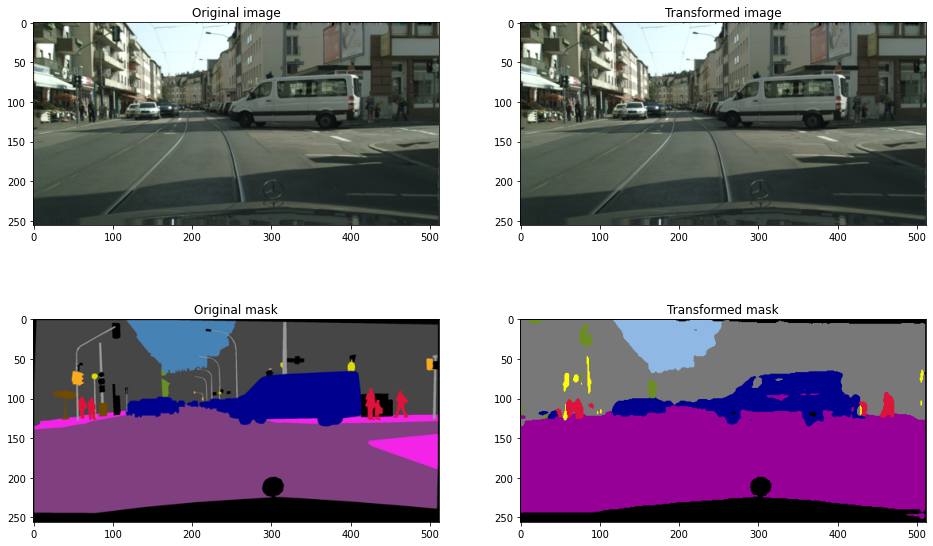

In [44]:
from PIL import Image
import numpy as np

from tensorflow.keras.utils import to_categorical
from scripts.helper_functions import get_classes, form_2D_label
from scripts.labels import labels

from scripts.helper_functions import label_to_mask, visualize
import matplotlib.pyplot as plt

class_labels = get_classes(labels)

img = df_valid.sample(1, ignore_index=True)
x_img_path = 'images/val/frankfurt_000000_002196_leftImg8bit.png'
y_img_path =  'ground_truth/val/frankfurt_000000_002196_gtFine_color.png'
# x_img_path = img['xPathLabel'][0]
# y_img_path = img['yPathLabel'][0]


x_img = Image.open(mounted_drive + x_img_path).convert('RGB')
x_image = x_img.resize((512,256))
x_array = np.array(x_image)

y_img = Image.open(mounted_drive + y_img_path).convert('RGB')
y_image = y_img.resize((512,256))
y_array = np.array(y_image)
img_array_2D = form_2D_label(y_array, class_labels[0])
y_cat = to_categorical(img_array_2D, num_classes=8)

test_image = x_array

mask = selected_model.predict(np.expand_dims(test_image, 0))[0]

mask_3D = label_to_mask(mask)
plt.imsave('test_mask.png', mask_3D)


visualize(test_image, mask, test_image, y_array)

In [40]:
from scripts.model_and_metrics import dice_coeff

prediction_1D = tf.reshape(mask, (-1, 8))
y_array_1D = tf.reshape(y_cat, (-1, 8))

coef = dice_coeff(prediction_1D, y_array_1D)
tf.print(coef)

0.726959825


#### display confusion matrix

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def display_confusion_matrix(cm, fmt=".1%"):
    fig, ax = plt.subplots(figsize=(14, 8))

    heatmap = sns.heatmap(cm, annot=True, cmap='Greens', fmt=fmt, ax=ax)
    ax.set_xlabel("Prediction", labelpad=20)
    ax.set_ylabel("Ground truth", labelpad=10)
    ax.set_title("Confusion Matrix on valid dataset")

    # On ajoute des bordure pour indique le sens de lecture
    for i in range(cm.shape[0]):
        ax.add_patch(plt.Rectangle((0, i), cm.shape[1], 1, ec='black', fc='none', lw=1))

    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color("black")

    plt.show()

def get_confusion_matrix(model, dataGen, classes_nb, 
                        normalize=True, display_cm=False):
    
    confusion_matrix = tf.zeros((classes_nb, classes_nb), dtype=tf.int32)

    for image_batch, label_batch in dataGen:
        # predict label with selected model
        pred_batch = model.predict(image_batch)

        # choose the max for each pixel
        label_batch = tf.math.argmax(label_batch, axis=-1)
        pred_batch = tf.math.argmax(pred_batch, axis=-1)

        # we set tensors to 1D
        label_batch = tf.reshape(label_batch, [-1])
        pred_batch = tf.reshape(pred_batch, [-1])

        # Get confusion matrix for each batch and sum all up
        confusion_matrix += tf.math.confusion_matrix(label_batch, pred_batch, num_classes=classes_nb)

    # Get class names
    classes_names = ['void','flat','construction',
                     'object','nature','sky','human',
                     'vehicle']

    # put all into pd.DF
    confusion_matrix = pd.DataFrame(
        confusion_matrix.numpy(),
        columns=classes_names,
        index=classes_names
    )

    if normalize:
        # sum of pixels for each class
        classes_px_nb = confusion_matrix.sum(axis=1)

        # we normalize with sum above
        for c in confusion_matrix.columns:
            confusion_matrix[c] = confusion_matrix[c] / classes_px_nb

    if display_cm == True:
        display_confusion_matrix(confusion_matrix)

    return confusion_matrix

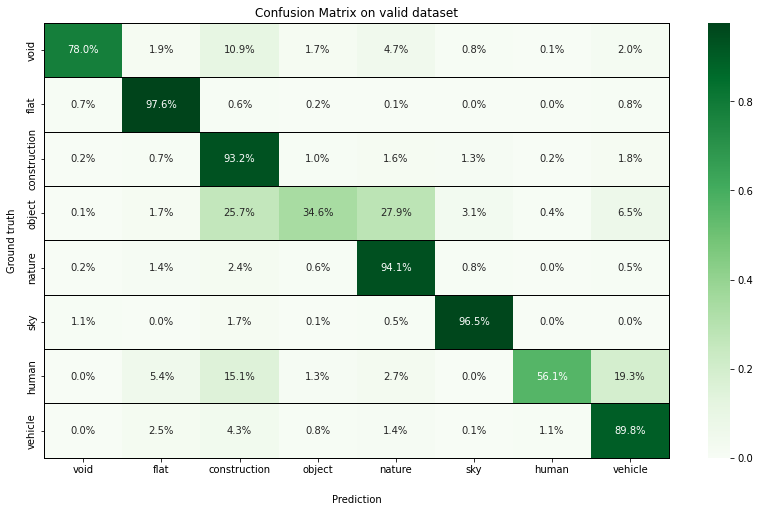

In [9]:
cm = get_confusion_matrix(selected_model, validGen.dataset, 8, 
                          display_cm=True)


# Deployer le modèle sur Azure

##### define the parameters

In [58]:
from azureml.core import Run, Dataset, Workspace

WS_NAME = os.environ.get('WS_NAME')
SUBSCRIPTION = os.environ.get('SUBSCRIPTION_ID_FREE_STUDENTS')
RESSOURCE_GROUP = os.environ.get('RESSOURCE_GROUP')

ws = Workspace(SUBSCRIPTION, RESSOURCE_GROUP, WS_NAME)
print(ws)


MODEL_NAME = 'p8_model'
SERVICE_NAME = 'p8-endpoint'
ENV_NAME = 'p8_env'

SOURCE_DIR = 'azure_deploy/'
DEPLOY_SCRIPT = 'score.py'

Workspace.create(name='p8_ws', subscription_id='d4258567-1f40-439d-93e3-23364c743517', resource_group='OpenClassroms')


#####  set up config

In [59]:
from azureml.core import Workspace, Model

from azureml.core import Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

VERSION = 28
model = Model(ws, MODEL_NAME, version=VERSION)

env = Environment.get(workspace=ws, name=ENV_NAME)
env.inferencing_stack_version='latest'

service_name = SERVICE_NAME

aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=4)

inference_config = InferenceConfig(environment=env,
                                source_directory=SOURCE_DIR,
                                entry_script=DEPLOY_SCRIPT)

##### deploy the config

In [65]:
# On déploie le modèle
service = Model.deploy(
    workspace=ws, 
    name=service_name,
    models=[model],
    inference_config=inference_config, 
    deployment_config=aci_config,
    overwrite=True
)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-01-07 10:40:01+01:00 Creating Container Registry if not exists.
2022-01-07 10:40:04+01:00 Use the existing image.
2022-01-07 10:40:04+01:00 Generating deployment configuration.
2022-01-07 10:40:05+01:00 Submitting deployment to compute.
2022-01-07 10:40:10+01:00 Checking the status of deployment p8-endpoint..
2022-01-07 10:47:23+01:00 Checking the status of inference endpoint p8-endpoint.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [67]:
# print(service.get_logs())
print(service.scoring_uri)

http://83884bbd-148f-43b2-a990-54f432df4c15.northeurope.azurecontainer.io/score


##### test API

In [56]:
import json
from json import JSONEncoder
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [57]:
import pathlib
import requests, json
import numpy as np
import matplotlib.pyplot as plt

# from azureml.core.webservice import AciWebservice

# service = AciWebservice(ws, SERVICE_NAME)

# in live Azureml portal
# uri = service.scoring_uri

# in local debug with azure ml inference server
uri = 'http://127.0.0.1:5001/score'

headers = {"Content-Type": "application/json", 'Accept':'application/json'}

data_to_send = {"image_name": 'frankfurt_000001_002646'}

response = requests.post(uri, json=data_to_send, headers=headers)

if not response.ok:
    print(f"Erreur de type {response.status_code}")
else:
    # print("Decode JSON serialized NumPy array")
    decodedArrays = json.loads(response.text)

    # return from http has double dict {image: {'image': array}}
    # so we decode to json one second time (after decoding response.text)
    final_image_to_dict = json.loads(decodedArrays["image"])
    final_mask_to_dict = json.loads(decodedArrays["mask"])
    final_pred_to_dict = json.loads(decodedArrays["pred"])
    # and then we use the values from each key
    final_image = np.asarray(final_image_to_dict["image"])
    final_mask = np.asarray(final_mask_to_dict["mask"])
    final_pred = np.asarray(final_pred_to_dict["pred"])

    
    PATH_FOR_DWNLD_IMG = '00 data/REST_API/'
    pathlib.Path(PATH_FOR_DWNLD_IMG).mkdir(parents=True, exist_ok=True)

    # save pictures (need to convert them to unit8 or float)
    plt.imsave(PATH_FOR_DWNLD_IMG + 'img.png', np.uint8(final_image))
    plt.imsave(PATH_FOR_DWNLD_IMG + 'mask.png', np.uint8(final_mask))
    plt.imsave(PATH_FOR_DWNLD_IMG + 'pred.png', np.uint8(final_pred))


##### KILL THE API

In [73]:
service.delete()